In [9]:
import numpy as np
import sys
sys.path.append('../../')
sys.path.append('../../pyfos/')
from pyfos.models.feedforward import build_feedforward
from pyfos.generic.optimizer import gd_optimizer
from pyfos.generic.regularizers import gaus_prior
from functools import partial 
from pyfos.tc.simple import  simple_tc
from pyfos.tc.cv import  cv_tc
from pyfos.hyperoptimizers.random_search import random_optimize
from pyfos.hyperoptimizers.greed_optimize import greed_optimize
import theano
%matplotlib inline
import matplotlib.pylab as plt
import random
import cPickle

In [10]:
with open('./results_cv_mad.pckl', 'rb') as inp:
    mad = cPickle.load(inp)
with open('./results_cv_rand.pckl', 'rb') as inp:
    rand = cPickle.load(inp)    
with open('./results_cv_greed.pckl', 'rb') as inp:
    greed = cPickle.load(inp)
with open('./results_cv_hoag.pckl', 'rb') as inp:
    hoag = cPickle.load(inp)
matrix = np.load('../../../data/matrix.npy')
X, Y = np.load('../../../data/linearx.npy'), np.load('../../../data/lineary.npy')
X_train = X[:100]
Y_train = Y[:100]
X_test = X[100:]
Y_test = Y[100:]

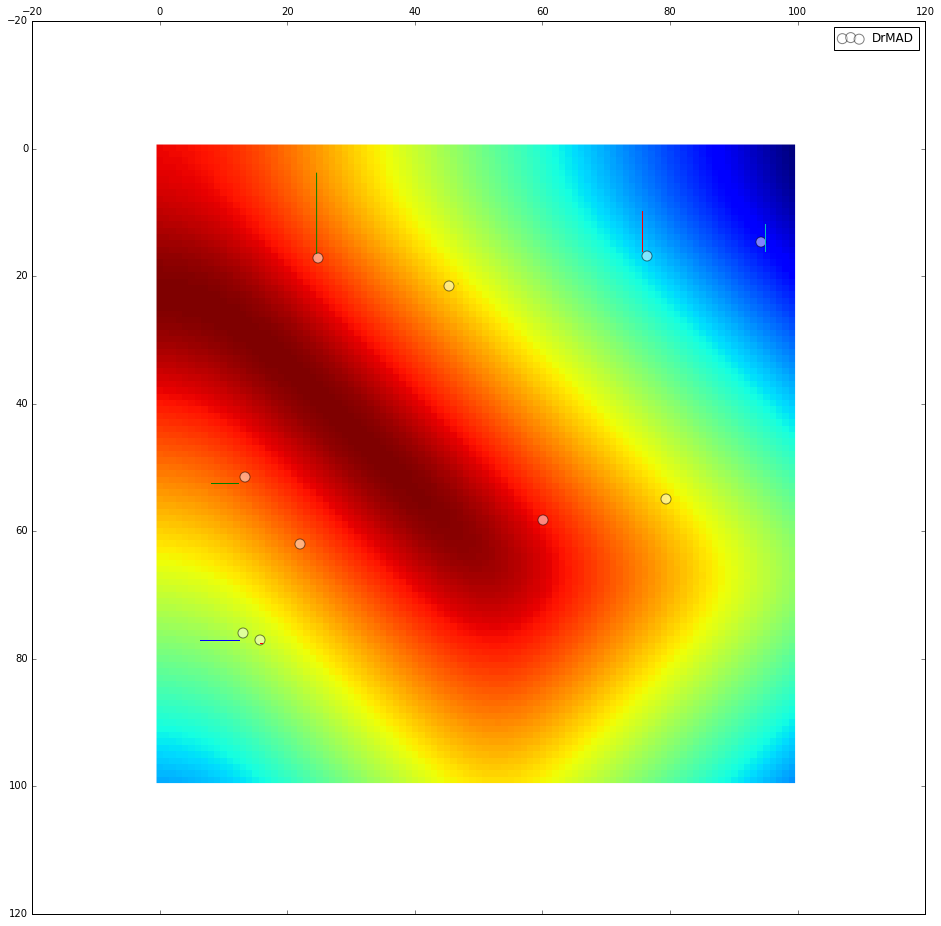

In [12]:
plt.matshow(matrix.T)
for dataset, label, c in [(mad, 'DrMAD', 'w'), 
                         #(rand, 'Random', 'g'),
                        #(greed, 'Greed', 'r'),
                         #(hoag, 'HOAG', 'b'),
                        ]:
    first = True
    for i in dataset:
        first_value = i.history[0][0][0]
        i = i.best_values[0]
        
        
        first_value = np.log10(np.exp(2*first_value))*10
        i = np.log10(np.exp(2*i))*10 
        if first:
            plt.scatter(i[0] + np.random.randn(1)*1,i[1]+ np.random.randn(1)*1, c=c, label=label, alpha=0.5, s=100)
            first = False
        else:
            plt.scatter(i[0]+ np.random.randn(1)*1,i[1]+ np.random.randn(1)*1, c=c, alpha=0.5, s=100)
        #print [first_value[0], i[0]],[first_value[1], i[1]]
        plt.plot([first_value[0], i[0]],[first_value[1], i[1]])
        
plt.legend(loc='best')
plt.rcParams['figure.figsize'] = (20,20)

#plt.scatter(2713%100 ,2713/100, s=1000)


DrMAD
-137.843477688
Random
-137.843376389
Greed
-137.843377944


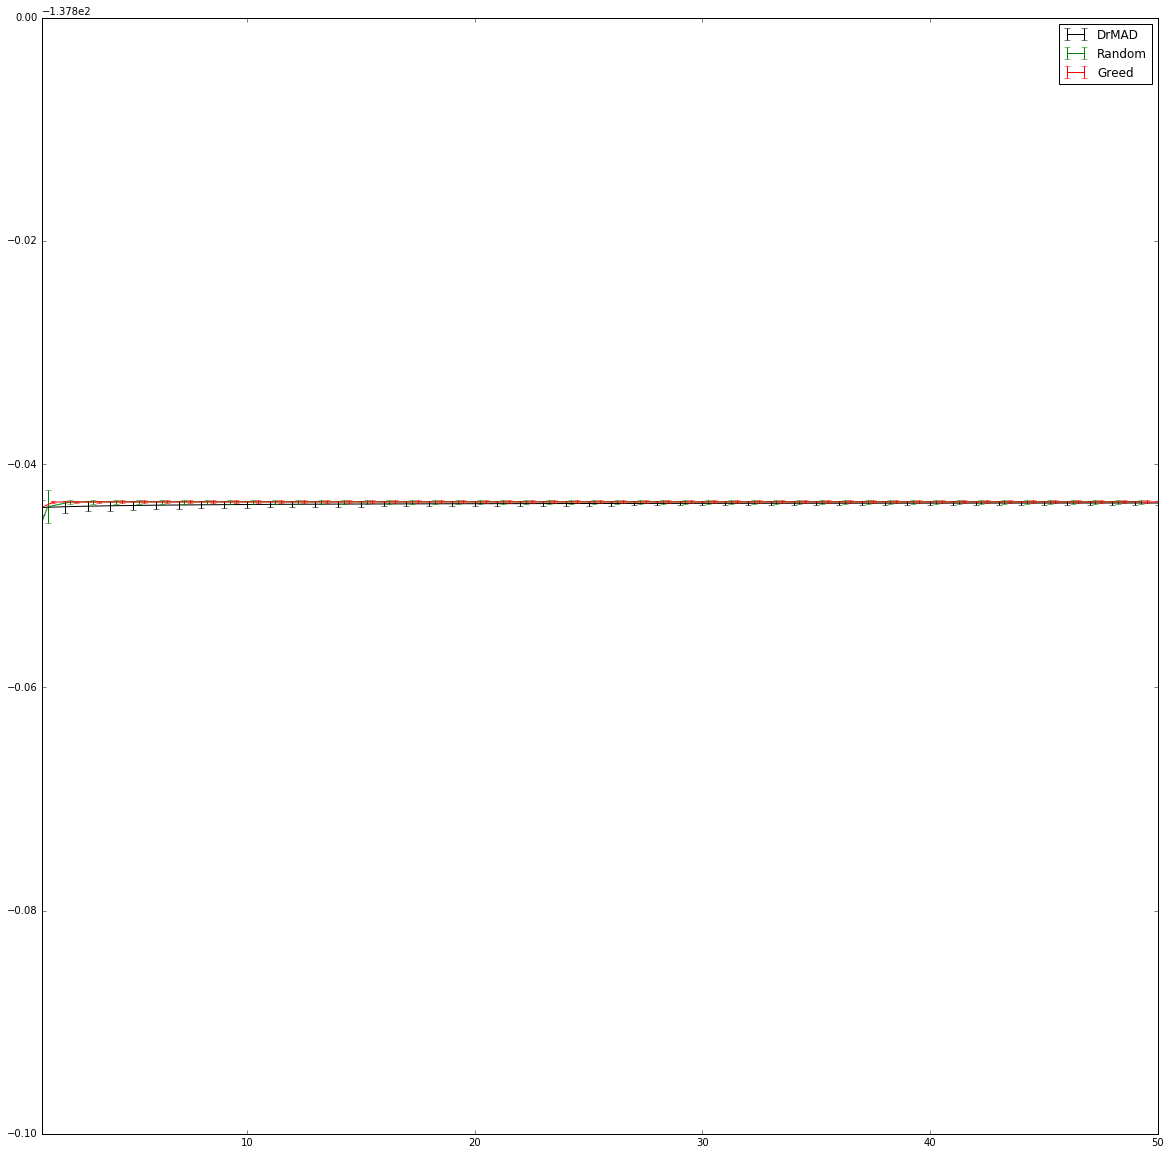

In [16]:
id = -1
for dataset, label, c in [(mad, 'DrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         #(hoag, 'HOAG', 'b')
                          ]:
    id+=1
    
    line = []
    for b in dataset:
        
        history = []
        for i in xrange(0, len(b.history)):
        
            best_value = max([h[1] for h in b.history[:i+1]])
        
            history.append(best_value)
        line.append(history)
    print label
    print np.mean(line, axis=0)[-1]
   
    #plt.fill_between(range(len( np.mean(line, axis=0))),  np.mean(line, axis=0)-np.std(line, axis=0), np.mean(line, axis=0)+np.std(line, axis=0), facecolor=c, alpha=0.25 )
    plt.errorbar(np.array(range(len(line[0])))+id*1.0/4, np.mean(line, axis=0), yerr=np.std(line, axis=0), c=c, lw=1, label=label)
    #plt.plot( np.mean(line, axis=0), label=label, c=c, lw=3)
plt.ylim((-137.9, -137.8))
plt.xlim((1,50))
plt.legend(loc='best')


start
DrMAD
0.0114851092788 2.79931698545e-06
Random
0.0123030059656 0.0040552617338
Greed
0.0118479820624 0.000465281629797
HOAG
0.011487301998 2.64711688491e-06


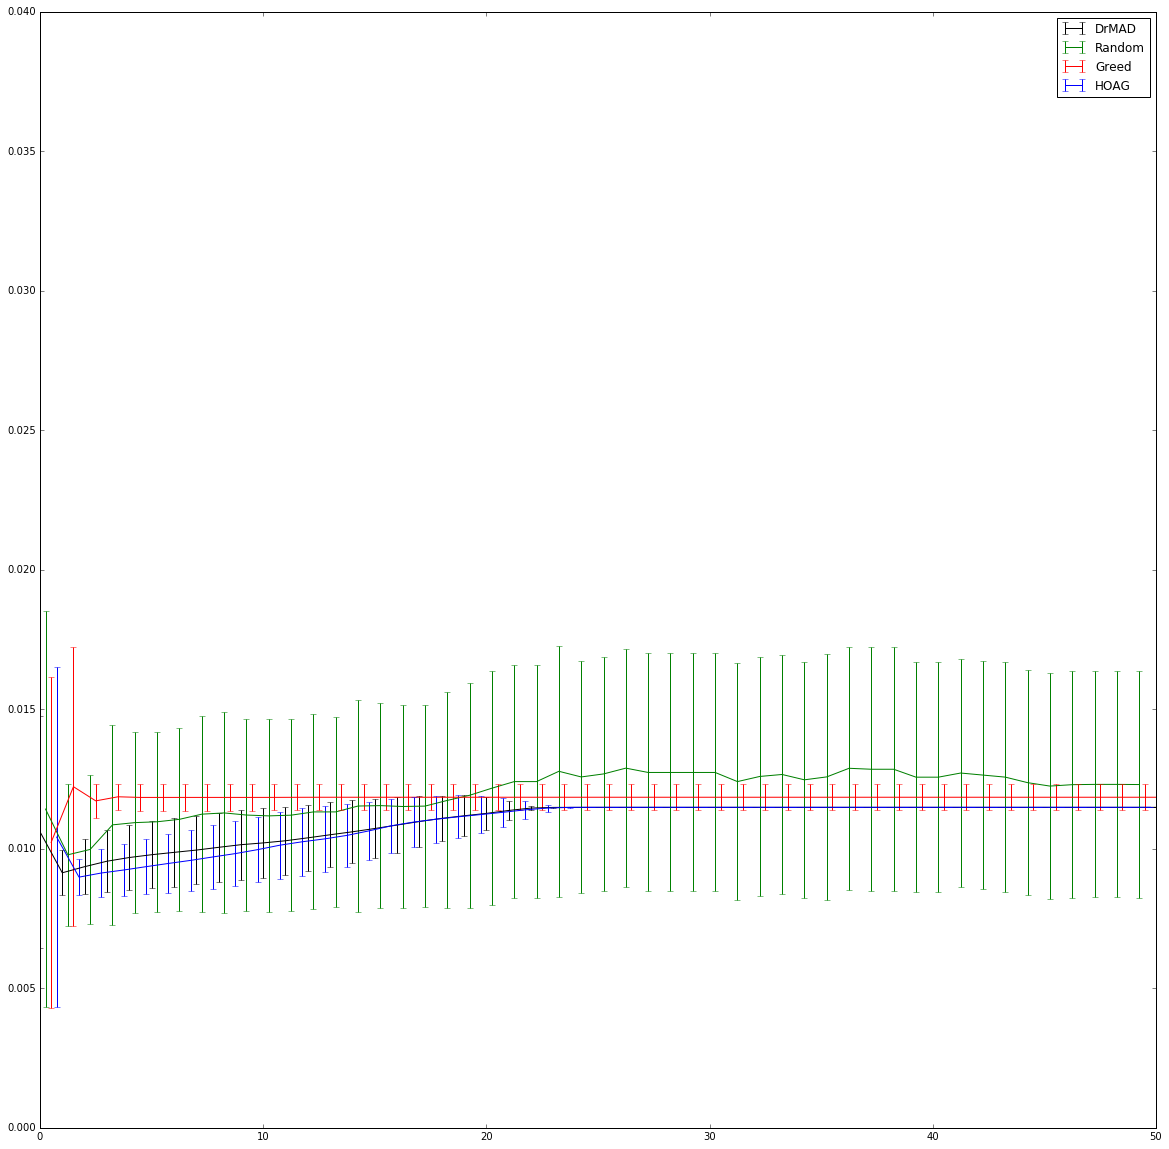

In [32]:
import theano.tensor as T
lr = theano.shared(0.01)
alphas = theano.shared(np.array([1.0, 1.0]))
optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward, structure = [2,1], nonlinearity=lambda x:x, log_alphas =alphas, bias=False)
#model_build = partial(build_var_feedforward, structure = [2,1], nonlinearity=lambda x:x, log_alphas=alphas, bias=False, param_pool_size=100)
X_train = X[:100]
Y_train = Y[:100]
X_test = X[100:]
Y_test = Y[100:]
training_procedure = simple_tc( model_build, optimizer, X_train, Y_train,  batch_size=100 )



X_t = T.matrix()
result = []

predicts = []

for m in training_procedure.models:    
    predict = m.predict_var(X_t)
    predicts.append(theano.function([X_t], predict))
print 'start'
id = -1
for dataset, label, c in [
                         (mad, 'DrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    print label
    line = []

    for b in dataset:

        history = []
        for i in xrange(len(b.history)):
            try:
                best_value = np.argmax([h[1]  for h in b.history[:i+1] if not np.isnan(h[1])])
            except:
                continue
            best_value = b.history[best_value][0]
            #if i==len(b.history)-1:
            #    print best_value[0]
            alphas.set_value(best_value[0])
            
            


            for _ in xrange(10):
                training_procedure.do_train()
            res = []
            res = np.sqrt(np.mean((predicts[0](X_test)[:,0]-Y_test)**2))
            #if i==len(b.history)-1:
            #    print res
            
            history.append(res)
        #print res
        if len(history)>=50:
            line.append(history)
        
            


        """
        bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
         [alpha_ranges, lr_ranges], verbose=100))
        X = T.matrix()    
        model = model_build(dataset_size=100)


        """

    plt.errorbar(np.array(range(len(line[0])))+id*1.0/4, np.mean(line, axis=0), yerr=np.std(line, axis=0), c=c, lw=1, label=label)
    print  np.mean(line, axis=0)[-1], np.std(line, axis=0)[-1]
plt.ylim((0.0, 0.04))
plt.xlim((0, 50))
plt.legend(loc='best')

In [ ]:
plt.plot()

In [37]:
batch_size = 25
lr = theano.shared(10**(-5))
log_alphas = theano.shared(np.array([10.0]))

optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward,  structure = [X_train.shape[1], 50,   1],  init_sigmas=[0.001]*3,  nonlinearity=lambda x:T.nnet.relu(x), log_alphas=log_alphas, bias=True)
training_procedure = simple_tc( model_build, optimizer, X_train, Y_train,   batch_size=batch_size )
model = model_build(params=training_procedure.models[0].params, dataset_size=1)
X = T.matrix()
predict = theano.function([X], model.predict_var(X))

def mse(Y1, Y2):
    return np.sum((Y1 - Y2)**2)

#100 epochs, 2500/25 ~ 100 iterations
err = []
Y = predict(X_test)
err.append(mse(Y[:,0], Y_test))
for epoch in xrange(100):
    
    for i in xrange(100):
        training_procedure.do_train()
    
    Y = predict(X_test)
    err.append(mse(Y[:,0], Y_test))
    

    

In [27]:
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    print label
    line = []

    for b in dataset:

        history = []
        for i in xrange(len(b.history)):

            best_value = np.max([h[1] for h in b.history[:i+1]])
            history.append(best_value)
        history = np.array(history)
        history = history[-1]/history
        history = np.where(history>=0.99)[0]
       
        line.append(np.min(history))
        

        """
        bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
         [alpha_ranges, lr_ranges], verbose=100))
        X = T.matrix()    
        model = model_build(dataset_size=100)


        """
        
    print np.mean(line), np.median(line), np.std(line)

MrMAD
9.06 9.5 5.64060280467
Random
13.1 9.0 12.0370262108
Greed
1.14 1.0 1.13154761279
HOAG
9.94 11.0 5.04543357899


[0,
 0,
 0,
 0,
 0,
 41,
 41,
 0,
 42,
 20,
 0,
 21,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 45,
 21,
 38,
 0,
 38,
 0,
 21,
 0,
 40,
 0,
 21,
 41,
 0,
 38,
 0,
 0,
 40,
 41,
 0,
 41,
 44,
 0,
 21,
 1,
 41]

In [28]:
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    history = []
    for b in dataset:
        best_value = np.max([h[1] for h in b.history])
        history.append(best_value)
    print label, np.mean(history), np.std(history)

MrMAD -142.981621825 0.000227162117424
Random -143.604380101 0.534446507787
Greed -142.993744798 0.00556670676203
HOAG -142.981601504 0.000218235910363


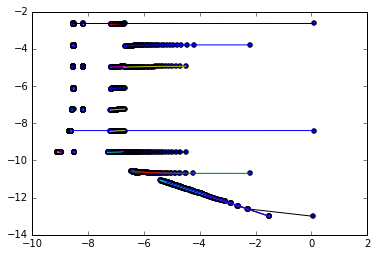

In [15]:
dataset = hoag
import theano.tensor as T
lr = theano.shared(0.01)
alphas = theano.shared(np.array([1.0, 1.0]))
optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward, structure = [2,1], nonlinearity=lambda x:x, log_alphas =alphas, bias=False)
X_train = X[:100]
Y_train = Y[:100]
X_test = X[100:]
Y_test = Y[100:]
training_procedure = simple_tc( model_build, optimizer, X_train, Y_train,  batch_size=100 )

for d in dataset:
    X_, Y_ = [], []
    for h in d.history:
        alphas.set_value(h[0][0])
        for _ in xrange(10):
              training_procedure.do_train()
        X_.append(np.linalg.norm(training_procedure.models[0].params.eval() - np.array([20, 100])))
        Y_.append(np.linalg.norm(np.exp(h[0][0]- np.array([2713%100, 2713/100]))))
    plt.scatter(np.log(X_),np.log(Y_))
    plt.plot(np.log(X_),np.log(Y_))

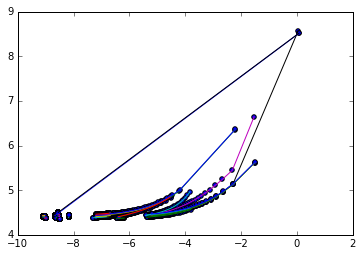

In [18]:
dataset = hoag
import theano.tensor as T
lr = theano.shared(0.01)
alphas = theano.shared(np.array([1.0, 1.0]))
optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward, structure = [2,1], nonlinearity=lambda x:x, log_alphas =alphas, bias=False)
X_train = X[:100]
Y_train = Y[:100]
X_test = X[100:]
Y_test = Y[100:]
training_procedure = simple_tc( model_build, optimizer, X_train, Y_train,  batch_size=100 )

for d in dataset:
    X_, Y_ = [], []
    for h in d.history:
        alphas.set_value(h[0][0])
        for _ in xrange(10):
              training_procedure.do_train()
        X_.append(np.linalg.norm(training_procedure.models[0].params.eval() - np.array([20, 100])))
        Y_.append(h[-1])
    plt.scatter(np.log(X_),np.log(-np.array(Y_)))
    plt.plot(np.log(X_),np.log(-np.array(Y_)))

In [8]:
Y_

[array(-277.29114686678855),
 array(-172.0529722751367),
 array(-144.604822027735),
 array(-130.54732451849281),
 array(-121.83425910611308),
 array(-115.85820765135955),
 array(-111.48760719898455),
 array(-108.14485094732697),
 array(-105.50206663098866),
 array(-103.35849231157151),
 array(-101.58397161486275),
 array(-100.0902594319505),
 array(-98.81532630205706),
 array(-97.71425190236292),
 array(-96.75368167212932),
 array(-95.90831490367741),
 array(-95.15860334906061),
 array(-94.48919871332782),
 array(-93.8878786398681),
 array(-93.34478712966856),
 array(-92.85188674876497),
 array(-92.40255664053902),
 array(-91.99129289576109),
 array(-91.61348205119077),
 array(-91.26522766886708),
 array(-90.94321600289554),
 array(-90.64461082999833),
 array(-90.3669703030455),
 array(-90.1081806203322),
 array(-89.8664026664511),
 array(-89.64002875450987),
 array(-89.42764730396243),
 array(-89.22801380386706),
 array(-89.04002679270404),
 array(-88.86270787075387),
 array(-88.69518